In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
from sys import stdout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
%matplotlib inline

# Dinâmica Molecular usando OpenMM

https://openmm.org/

## Instalando o OpenMM

Instalação em CPU

In [2]:
# !conda install -c conda-forge openmm
# pip install openmm

Instalação em GPU

In [3]:
# !conda install -c conda-forge openmm cuda-version=12 # para usar GPU
# pip install openmm[cuda12] # para usar com GPU

## Importando a Biblioteca

In [4]:
import mdtraj
import nglview

from openmm.app import *
from openmm import *
from openmm.unit import *

## Input com posição das partículas

In [5]:
xyz_data = pd.read_csv('../data/positions-N=864-rho=0.840-kT=0.710.xyz',sep='\t',skiprows=2,names=['x','y','z'])

In [6]:
xyz_data

,x,y,z
0,9.50185,9.41310,6.58248
1,1.60217,1.90719,7.76761
2,9.16342,1.03461,8.71883
3,0.75624,1.66058,9.44078
4,6.96636,9.71882,4.82582
...,...,...,...
859,8.42259,1.89441,1.32876
860,7.71757,8.58243,8.21504
861,8.86400,8.68088,1.87669
862,0.66307,6.66686,4.02066


Criando array com posições

In [7]:
initial_positions = xyz_data[['x','y','z']].values / 11.0

Número total de partículas

In [8]:
N_atoms = initial_positions.shape[0]

Posição da partícula 0

In [9]:
initial_positions[0]

array([0.86380455, 0.85573636, 0.59840727])

Gráfico das posições em $x$ e $y$

Text(0, 0.5, 'y')

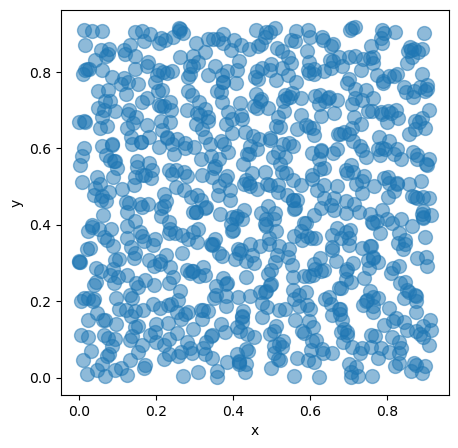

In [10]:
plt.figure(figsize=(5,5))
plt.plot(initial_positions[:,0],initial_positions[:,1],'o',ms=10.0,alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')

## Simulação NVE no OpenMM

Variáveis das partículas de LJ (no caso Argônio)

In [11]:
# Parâmetros físicos do argônio
epsilon = 117.8 * kelvin * BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA
sigma = 3.419 * angstrom
mass = 39.948 * amu

# Parâmetros da simulação 
cutoff = 2.5*sigma

print(epsilon)

979.4436964184517 J/mol


Condição termodinâmica

In [12]:
rho = 0.84/sigma**3

print(rho)

0.021017544890034698 /(A**3)


Tamanho da caixa

In [13]:
L = (N_atoms/rho)**(1/3)

print(L)

34.512566219789825 A


`system`: número de partículas e suas massas, vetores da célula (caixa de simulação)

In [14]:
system = System()
for i in range(N_atoms):
    system.addParticle(mass)

In [15]:
box_matrix = L * np.identity(3)
system.setDefaultPeriodicBoxVectors(*box_matrix)

Qual o número de partículas?

In [16]:
system.getNumParticles()

864

`topology`: identifica os átomos e informações relacionadas: ligações química, resíduos e cadeias.

Todos os átomos de argônio são agrupados em um resíduo e uma cadeia. Essa informação é necessária para escrever arquivos PDB.

In [17]:
# Define a relatively boring topology object.
topology = Topology()
topology.setPeriodicBoxVectors(box_matrix)
chain = topology.addChain()
residue = topology.addResidue("argon", chain)
element_Ar = Element.getByAtomicNumber(18)
for _iatom in range(N_atoms):
    topology.addAtom("Ar", element_Ar, residue)

`force`: define qual o topo de interação modificará as velocidades e as posições das partículas

- existem campos de força já definidos ou usuário pode criar
- adiciona essa info ao sistema

In [18]:
energy = '4*epsilon*((sigma/r)^12-(sigma/r)^6); sigma=(sigma1+sigma2)/2; epsilon=sqrt(epsilon1*epsilon2)'
force = CustomNonbondedForce(energy)
force.addPerParticleParameter('sigma')
force.addPerParticleParameter('epsilon')
for i in range(N_atoms):
    force.addParticle([sigma,epsilon])
force.setCutoffDistance(cutoff)
force.setNonbondedMethod(force.CutoffPeriodic)
force_index = system.addForce(force)

`integrator`: define o integrador a ser utilizado (Verlet para NVE)

In [19]:
dt = 3 * femtoseconds # (10^-15 s)
integrator = VerletIntegrator(dt)

`platform`: define qual plataforma usar (CPU, CUDA)

In [20]:
platform = Platform.getPlatformByName('CPU')

`simulation`: une a topologia, sistema, integrador e a plataforma. Contem todas as informações do estado do sistema: posições, velocidades, outros parametros

In [21]:
# Define um objeto de simulação
simulation = Simulation(topology, system, integrator, platform,)

# Inicializa as posições iniciais
simulation.context.setPositions(initial_positions * L)

# Inicializa velocidades com valores aleatórios à temperatura de 300K.
simulation.context.setVelocitiesToTemperature(300 * kelvin)

`state`: uma fotografia do estado do sistema. Necessário para acessar as posições, energias e forças

In [22]:
state = simulation.context.getState(getEnergy=True, getForces=True)

Energia Potencial Inicial

In [23]:
state.getPotentialEnergy()

Quantity(value=-2000.886305809021, unit=kilojoule/mole)

Energia Cinética Inicial

In [24]:
state.getKineticEnergy()

Quantity(value=3345.254993495627, unit=kilojoule/mole)

Força sobre uma partícula

In [25]:
state.getForces()[0]

Quantity(value=Vec3(x=139.60711669921875, y=-12.410024642944336, z=114.9868392944336), unit=kilojoule/(nanometer*mole))

A célula seguinte define todos os reporters e realiza a simulação de MD

In [26]:
# Remove reporters existentes, no caso dessa célula ser executada mais de uma vez.
simulation.reporters = []

# Escreve a geometria inicial com um arquivo PDB
positions = simulation.context.getState(getPositions=True).getPositions()
with open("ljinit.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

# Escreve cada frame em arquivo DCD de trajetórias a cada 1000 passos
simulation.reporters.append(DCDReporter("ljtraj.dcd", 1000))

# Escreve num arquivo csv a cada 100 passos 
simulation.reporters.append(
    StateDataReporter(
        "ljscalars.csv",
        10,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True
    )
)

# Escreve na tela a cada 1000 passos 
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True)
)

# Roda a simulação molecular com 40000 passos
simulation.step(40000)

# A próxima linha é necessária para Windows para fechar os arquivos antes de serem abertos
del simulation

#"Step","Temperature (K)"
1000,385.8123991077645
2000,394.041200234332
3000,393.1248984579286
4000,389.21161714031405
5000,395.98180183186065
6000,405.02198832995174
7000,404.4710659457747
8000,395.28460456024476
9000,397.7237561129049
10000,397.42159307267127
11000,403.6180568289096
12000,396.2230021863279
13000,402.8206619521811
14000,395.3152559976529
15000,402.5155272867977
16000,414.385235902308
17000,396.2190720878543
18000,400.28448236869303
19000,400.04638090669107
20000,389.06056397896884
21000,406.32447507593156
22000,396.2408635489543
23000,403.9575729894107
24000,411.0286733272918
25000,393.31884645118873
26000,392.0944384859825
27000,397.8973226372046
28000,396.1336367678508
29000,400.6652066397636
30000,408.9361433772871
31000,403.13165819526176
32000,413.82448041768254
33000,412.4746760227289
34000,396.0164764490639
35000,397.4204988079363
36000,406.76301051503617
37000,395.7835307571675
38000,395.0161649008311
39000,395.5306144197251
40000,400.68959797132015


### Análise dos dados

In [27]:
traj = mdtraj.load("ljtraj.dcd", top="ljinit.pdb")
view = nglview.show_mdtraj(traj)
view.add_unitcell()
view

NGLWidget(max_frame=39)

In [28]:
df = pd.read_csv("ljscalars.csv")

In [29]:
df.head()

,"#""Step""",Time (ps),Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K)
0,10,0.03,-2101.877482,1344.308434,319.815506
1,20,0.06,-2293.002413,1344.094521,337.532572
2,30,0.09,-2488.572518,1345.047473,355.770451
3,40,0.12,-2684.634329,1345.009364,373.961988
4,50,0.15,-2891.930446,1345.496966,393.244887


In [30]:
df['Total Energy (kJ/mole)']

0       1344.308434
1       1344.094521
2       1345.047473
3       1345.009364
4       1345.496966
           ...     
3995    1355.091223
3996    1354.714299
3997    1354.344303
3998    1354.703695
3999    1354.353885
Name: Total Energy (kJ/mole), Length: 4000, dtype: float64

Text(0, 0.5, 'T (K)')

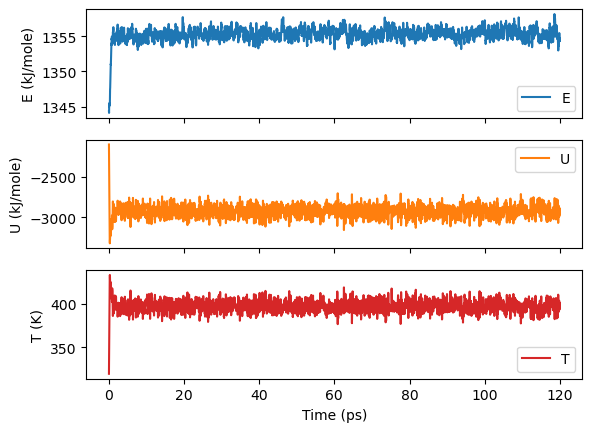

In [31]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(df['Time (ps)'],df['Total Energy (kJ/mole)'],label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel('E (kJ/mole)')

axs[1].plot(df['Time (ps)'],df['Potential Energy (kJ/mole)'],color='C1',label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel('U (kJ/mole)')

axs[2].plot(df['Time (ps)'],df['Temperature (K)'],color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time (ps)')
axs[2].set_ylabel('T (K)')

In [32]:
df['Temperature (K)'][df['Time (ps)'] > 10]

333     399.962101
334     403.405773
335     404.067512
336     404.707103
337     408.934440
           ...    
3995    400.093209
3996    396.262895
3997    393.424878
3998    395.348156
3999    400.689598
Name: Temperature (K), Length: 3667, dtype: float64

In [33]:
subsetT = df['Temperature (K)'][df['Time (ps)'] > 10]
subsetU = df['Potential Energy (kJ/mole)'][df['Time (ps)'] > 10]

In [34]:
from IPython.display import display, Math

Umean = subsetU.mean()
sigmaU = subsetU.std()

display(Math(rf"U = {Umean:.2f} \pm {sigmaU:.2f}\ kJ/mole"))

<IPython.core.display.Math object>

In [35]:
Tmean = subsetT.mean()
sigmaT = subsetT.std()

display(Math(rf"$T = {Tmean:.2f} \pm {sigmaT:.2f}\ K"))

<IPython.core.display.Math object>

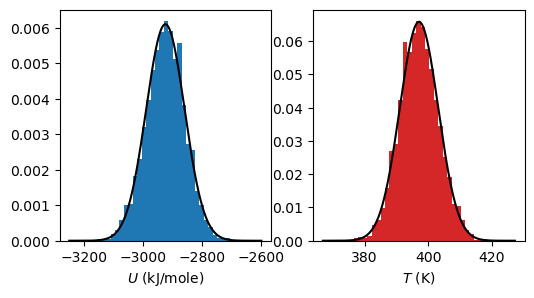

In [36]:
fig, axs = plt.subplots(1, 2,figsize=(6,3))

axs[0].hist(subsetU,bins=30,density=True)
axs[0].set_xlabel(r'$U$ (kJ/mole)')

uarray = Umean+np.arange(-5*sigmaU,5*sigmaU,0.01*sigmaU)
axs[0].plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

axs[1].hist(subsetT,bins=30,density=True,color='C3')
axs[1].set_xlabel(r'$T$ (K)')

Tarray = Tmean + np.arange(-5*sigmaT,5*sigmaT,0.01*sigmaT)
axs[1].plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

## Simulação NVT no OpenMM

In [37]:
temperature = 300 * kelvin
integrator = LangevinIntegrator(temperature, 1 / picosecond, 3 * femtoseconds)

In [38]:
# Define um objeto de simulação
simulation = Simulation(topology, system, integrator, platform,)

# Inicializa as posições iniciais
simulation.context.setPositions(initial_positions * L)

# Inicializa velocidades com valores aleatórios à temperatura de 300K.
simulation.context.setVelocitiesToTemperature(temperature)

In [39]:
# Remove reporters existentes, no caso dessa célula ser executada mais de uma vez.
simulation.reporters = []

# Escreve a geometria inicial com um arquivo PDB
positions = simulation.context.getState(getPositions=True).getPositions()
with open("ljinit.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

# Escreve cada frame em arquivo DCD de trajetórias a cada 1000 passos
simulation.reporters.append(DCDReporter("ljtraj.dcd", 1000))

# Escreve num arquivo csv a cada 100 passos 
simulation.reporters.append(
    StateDataReporter(
        "ljscalars.csv",
        10,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True
    )
)

# Escreve na tela a cada 1000 passos 
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True)
)

# Roda a simulação molecular com 40000 passos
simulation.step(40000)

# A próxima linha é necessária para Windows para fechar os arquivos antes de serem abertos
del simulation

#"Step","Temperature (K)"
1000,314.4685508909466
2000,292.3380970632542
3000,293.3969006179202
4000,294.33203017807006
5000,314.984704616821
6000,312.32964121508115
7000,295.61664573301204
8000,302.1765816450055
9000,317.8205829322633
10000,296.14874100734056
11000,296.60944169034394
12000,308.60888718434114
13000,296.6346348090895
14000,300.57355527564624
15000,297.7060241706915
16000,311.1818446707259
17000,299.6763618835495
18000,300.02111198505753
19000,297.1305376822647
20000,305.3155265202779
21000,296.22079486293063
22000,306.24801609512696
23000,314.0457440487754
24000,297.0742314025083
25000,294.80742915922247
26000,302.756657319765
27000,316.73683821228855
28000,303.6645987927132
29000,301.94795381324985
30000,302.9125280300205
31000,295.172776795748
32000,300.4791563267404
33000,291.5811771028075
34000,313.2286433872512
35000,286.8675200339143
36000,289.48491465470414
37000,295.4521497290022
38000,302.7406741516015
39000,284.3653132160839
40000,312.90023859691246


### Análise dos dados 

In [40]:
traj = mdtraj.load("ljtraj.dcd", top="ljinit.pdb")
view = nglview.show_mdtraj(traj)
view.add_unitcell()
view

NGLWidget(max_frame=39)

In [41]:
df = pd.read_csv("ljscalars.csv")

Text(0, 0.5, 'T (K)')

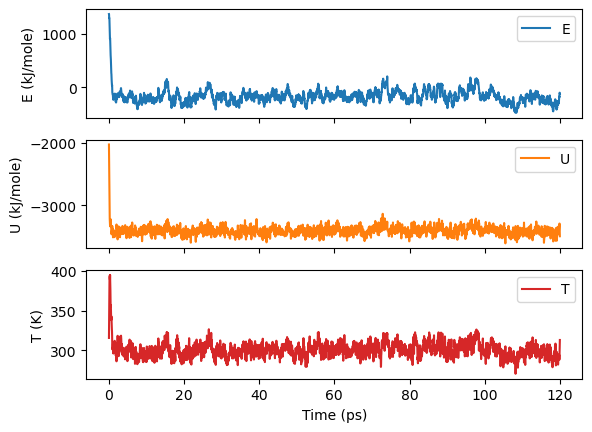

In [42]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(df['Time (ps)'],df['Total Energy (kJ/mole)'],label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel('E (kJ/mole)')

axs[1].plot(df['Time (ps)'],df['Potential Energy (kJ/mole)'],color='C1',label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel('U (kJ/mole)')

axs[2].plot(df['Time (ps)'],df['Temperature (K)'],color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time (ps)')
axs[2].set_ylabel('T (K)')

In [43]:
subsetT = df['Temperature (K)'][df['Time (ps)'] > 10]
subsetU = df['Potential Energy (kJ/mole)'][df['Time (ps)'] > 10]

# Energia Potencial
Umean = subsetU.mean()
sigmaU = subsetU.std()

display(Math(rf"U = {Umean:.2f} \pm {sigmaU:.2f}\ kJ/mole"))

# Temperatura
Tmean = subsetT.mean()
sigmaT = subsetT.std()

display(Math(rf"$T = {Tmean:.2f} \pm {sigmaT:.2f}\ K"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

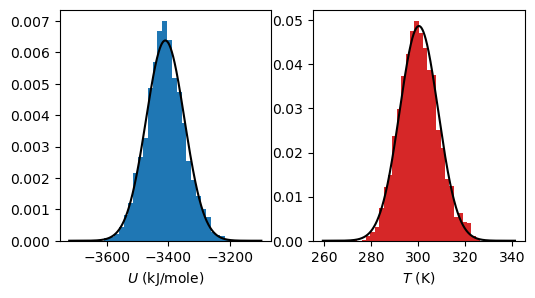

In [44]:
fig, axs = plt.subplots(1, 2,figsize=(6,3))

axs[0].hist(subsetU,bins=30,density=True)
axs[0].set_xlabel(r'$U$ (kJ/mole)')

uarray = Umean+np.arange(-5*sigmaU,5*sigmaU,0.01*sigmaU)
axs[0].plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

axs[1].hist(subsetT,bins=30,density=True,color='C3')
axs[1].set_xlabel(r'$T$ (K)')

Tarray = Tmean + np.arange(-5*sigmaT,5*sigmaT,0.01*sigmaT)
axs[1].plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> - Baixe a temperatura para $k_B T /\epsilon = 1.0$ e aumente a densidade para $\rho \sigma^3 = 1.2$ 
>